In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/nfl_scores_processed.csv')

# drop the 'schedule_date', 'weather_detail' and 'over_under_line' column
df = df.drop(['schedule_date', 'weather_detail', 'over_under_line'], axis=1)

# drop all rows with 'winner' = tie
df = df[df['winner'] != 'tie']

# create label encodings
team_names = df['team_home'].unique()
# sort team names alphabetically
team_names.sort()
# create a dict with team names as keys and ints from 1 to 32 as values
team_name_encoder = {}
for i in range(len(team_names)):
    team_name_encoder[team_names[i]] = i + 1

# home/away encoding
home_away_encoder = {'home': 0, 'away': 1 ,'PICK': 0.5}

# win/loss encoding
win_loss_encoder = {'win': 1, 'loss': 0, 'tie': 0.5}

# create reverse encoders
team_name_decoder = {v: k for k, v in team_name_encoder.items()}
home_away_decoder = {v: k for k, v in home_away_encoder.items()}
win_loss_decoder = {v: k for k, v in win_loss_encoder.items()}

# week replacements for postseason
df['schedule_week'] = df['schedule_week'].replace('Wildcard', '1')
df['schedule_week'] = df['schedule_week'].replace('Division', '2')
df['schedule_week'] = df['schedule_week'].replace('Conference', '3')
df['schedule_week'] = df['schedule_week'].replace('Superbowl', '4')

# convert the 'schedule_week' column to int
df['schedule_week'] = df['schedule_week'].astype(int)

# replace team names with ints in the df
df['team_home'] = df['team_home'].replace(team_name_encoder)
df['team_away'] = df['team_away'].replace(team_name_encoder)

# convert the 'team_favorite_id' column to 0 (home), 1 (away), 0.5 (PICK)
df['team_favorite_id'] = df['team_favorite_id'].replace(home_away_encoder)

# convert the 'winner' column to 0 (home) or 1 (away), 0.5 (tie)
df['winner'] = df['winner'].replace(home_away_encoder)

# convert the home_1, ..., home_10 columns to 0 (loss), 1 (win) or 0.5 (tie), same for away
for i in range(1, 11):
    df['home_' + str(i)] = df['home_' + str(i)].replace(win_loss_encoder)
    df['away_' + str(i)] = df['away_' + str(i)].replace(win_loss_encoder)

# replace 'NaN' string with np.nan
df = df.replace('NaN', np.nan)

# for all weather columns, fill the empty strings with the mean of the column
df['weather_temperature'].fillna(df['weather_temperature'].mean(), inplace=True)
df['weather_wind_mph'].fillna(df['weather_wind_mph'].mean(), inplace=True)
df['weather_humidity'].fillna(df['weather_humidity'].mean(), inplace=True)

df['weather_temperature'] = df['weather_temperature'].replace('', df['weather_temperature'].mean())
df['weather_wind_mph'] = df['weather_wind_mph'].replace('', df['weather_wind_mph'].mean())
df['weather_humidity'] = df['weather_humidity'].replace('', df['weather_humidity'].mean())

# drop all rows with 'NaN' values (games for which fewer than 10 games of history are available)
df = df.dropna()
print(df.head())
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('winner', axis=1), df['winner'], test_size=0.2, random_state=42)


     schedule_season  schedule_week  schedule_playoff  team_home  team_away  \
140             1979             11             False          6         19   
141             1979             11             False          7         18   
142             1979             11             False          8         29   
143             1979             11             False         10         22   
144             1979             11             False         11         30   

     team_favorite_id  spread_favorite  weather_temperature  weather_wind_mph  \
140               0.5              0.0                 28.0               6.0   
141               1.0             -4.0                 35.0              10.0   
142               0.0             -6.0                 36.0              12.0   
143               1.0             -1.0                 35.0              11.0   
144               1.0             -5.0                 72.0               0.0   

     weather_humidity  ...  home_6  aw

In [3]:
from sklearn.ensemble import RandomForestClassifier

# create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, max_depth=10)

# fit the model on the training data
rf.fit(X_train, y_train)

# predict on the test data
y_pred = rf.predict(X_test)

# calculate accuracy on the test data
accuracy = (y_pred == y_test).mean()
print(f'Test accuracy: {accuracy:.3f}')


Test accuracy: 0.777


GENERATE DEPENDENCE PLOTS

In [4]:
print(X_train.columns)


Index(['schedule_season', 'schedule_week', 'schedule_playoff', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'home_1',
       'away_1', 'home_2', 'away_2', 'home_3', 'away_3', 'home_4', 'away_4',
       'home_5', 'away_5', 'home_6', 'away_6', 'home_7', 'away_7', 'home_8',
       'away_8', 'home_9', 'away_9', 'home_10', 'away_10'],
      dtype='object')


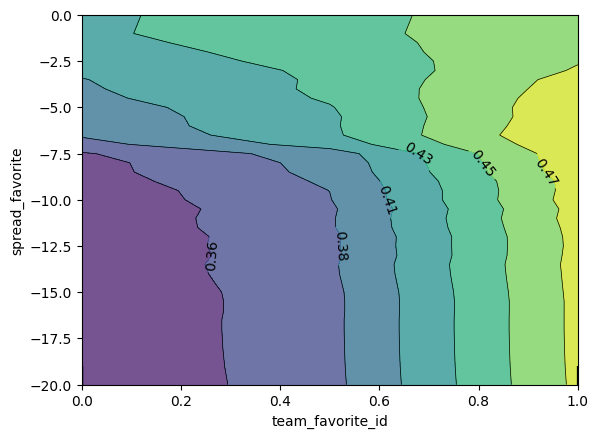

In [5]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# you have to select features by using their position in the df.columns list
features = [(5,6)]
# Create a PartialDependenceDisplay object
PartialDependenceDisplay.from_estimator(rf, X_test, features)
